### Flights delay Predictions 


#### Team Members: 
 * Manal Almaeen
 *  Yasha Ravindra

In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image 
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from math import sqrt
import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing  
from sklearn.preprocessing import StandardScaler  
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Overview of the dataset

#### The dataset is obtained form Kaggle. It containes 3 csv files which are : 
    1. airlines.csv: contains airline identifiers and airlines's names.
    2. airports.cvs: contains the airport's names and locations(city,state,LATITUDE,LONGITUDE)
    3. flights.csv : contains the flights information in 31 columns and 5714008 rows (Data, Airlines, ,FLIGHT NUMBER,TAIL NUMBER,ORIGIN AIRPORT,DESTINATION AIRPORT,...etc)

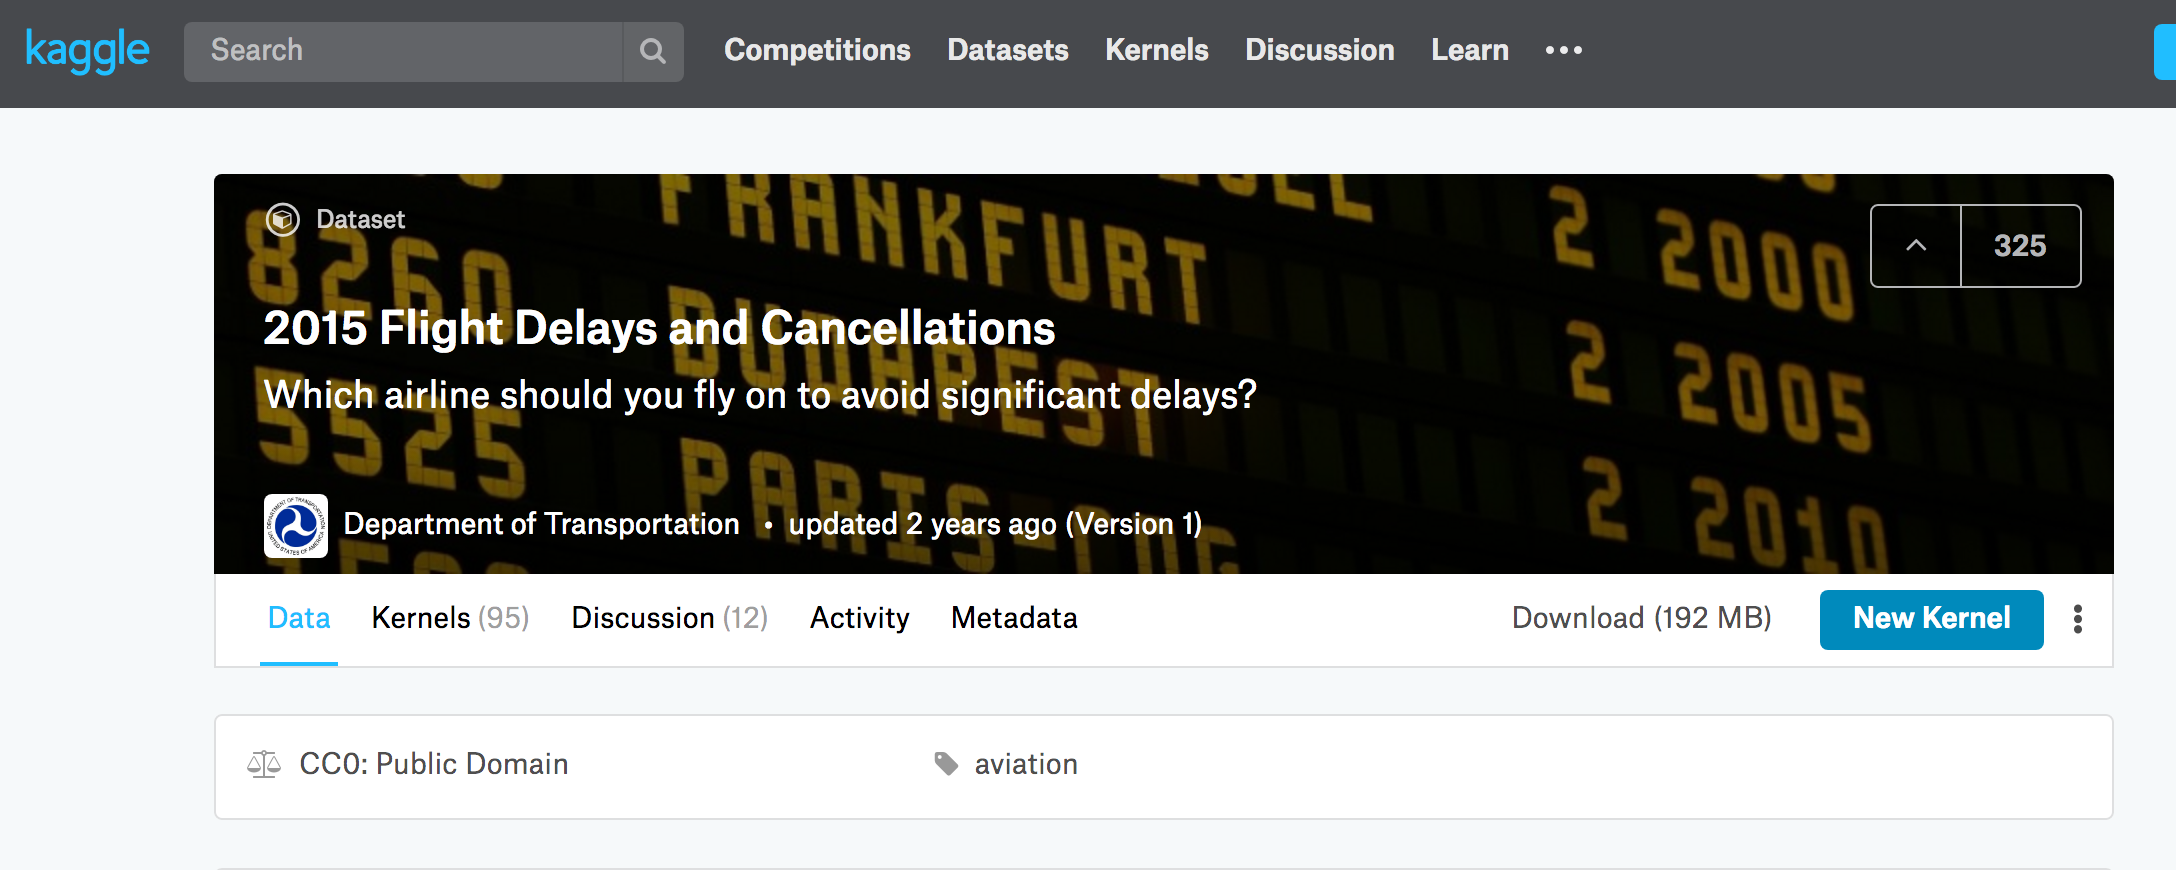

In [3]:
Image(filename='pic.png', width=750, height= 500, unconfined=True )

In [139]:
data = pd.read_csv("flights.csv", low_memory=False)
df = data.sample(800000)
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
4318999,2015,9,26,6,AA,1300,N3AXAA,MSY,DFW,1746,...,1908.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4031365,2015,9,8,2,HA,349,N484HA,KOA,OGG,910,...,935.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2564347,2015,6,11,4,US,671,N155UW,CLT,ATL,1559,...,1719.0,9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4690183,2015,10,20,2,AA,2000,N700UW,10693,11057,935,...,1146.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2552710,2015,6,10,3,WN,1015,N795SW,DAL,MDW,2210,...,218.0,113.0,0,0,NaN,0.0,0.0,8.0,105.0,0.0


In [97]:
data.shape

(5819079, 31)

In [98]:
# airline dataset
airline_N = pd.read_csv("airlines.csv")
airline_N.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [29]:
# we put the airline and IATA in dictionary
airlines_code = airline_N.set_index('IATA_CODE')['AIRLINE'].to_dict()
df['AIRLINES']= df['AIRLINE'].map(airlines_code)
data['AIRLINES']= data['AIRLINE'].map(airlines_code)

In [30]:
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
    
df['SCHEDULED_DEPARTURE']  = df['SCHEDULED_DEPARTURE'].apply(format_heure)
df['DEPARTURE_TIME']  = df['DEPARTURE_TIME'].apply(format_heure)
df['SCHEDULED_ARRIVAL']  = df['SCHEDULED_ARRIVAL'].apply(format_heure)
df['ARRIVAL_TIME'] =df['ARRIVAL_TIME'].apply(format_heure)

## A.  Exploring the missing values and cleaning the data

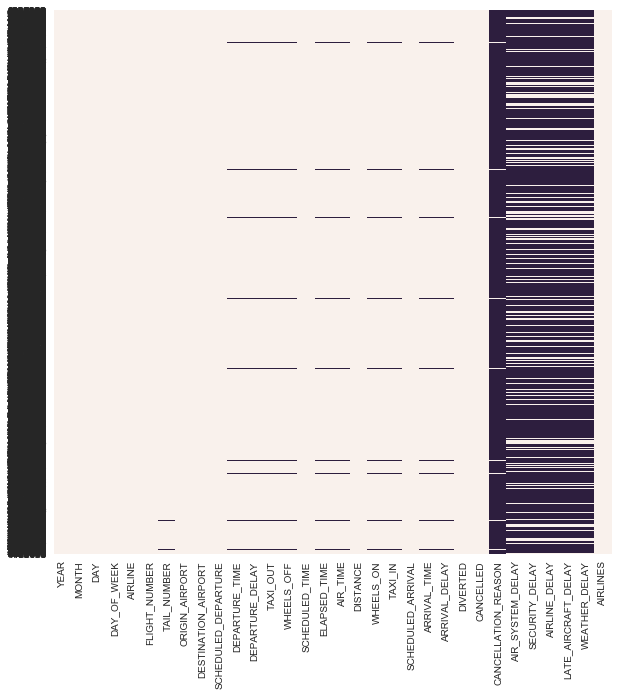

In [6]:
fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(df.isnull(), cbar=False, ax=ax)
#sns.heatmap(df.isnull(), cbar=False, )

#### Based on the prevoius heatmap, it seems that the last 6 col have more missing values than the actual.
#### So we will simply drop them from the original data and the sample.

In [140]:
data.drop(['CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY',
                 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY','YEAR'], axis=1, inplace = True)

In [141]:
df.drop(['CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY',
                'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'YEAR'], axis=1, inplace = True)

In [142]:
data = data.dropna(axis=0, subset=['DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
                           'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME',  'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME',
                           'ARRIVAL_DELAY'])

df = df.dropna(axis=0, subset=['DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
                           'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME',  'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME',
                           'ARRIVAL_DELAY'])

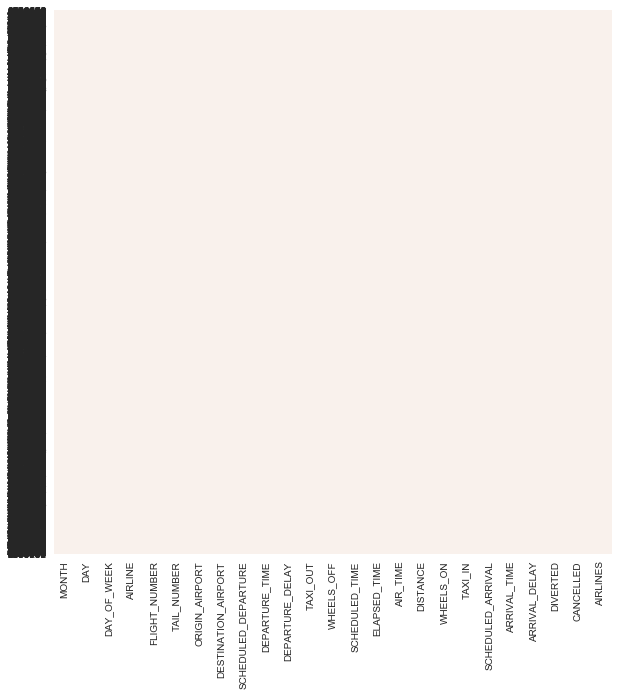

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.isnull(), cbar=False, ax=ax)

####  We can see now there is no missing values in our data !

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7852 entries, 1224170 to 2606760
Data columns (total 25 columns):
MONTH                  7852 non-null int64
DAY                    7852 non-null int64
DAY_OF_WEEK            7852 non-null int64
AIRLINE                7852 non-null object
FLIGHT_NUMBER          7852 non-null int64
TAIL_NUMBER            7852 non-null object
ORIGIN_AIRPORT         7852 non-null object
DESTINATION_AIRPORT    7852 non-null object
SCHEDULED_DEPARTURE    7852 non-null object
DEPARTURE_TIME         7852 non-null object
DEPARTURE_DELAY        7852 non-null float64
TAXI_OUT               7852 non-null float64
WHEELS_OFF             7852 non-null float64
SCHEDULED_TIME         7852 non-null float64
ELAPSED_TIME           7852 non-null float64
AIR_TIME               7852 non-null float64
DISTANCE               7852 non-null int64
WHEELS_ON              7852 non-null float64
TAXI_IN                7852 non-null float64
SCHEDULED_ARRIVAL      7852 non-null object
A

#### Removing the duplicated data a

In [143]:
df.drop_duplicates(keep = 'first', inplace=True)
data.drop_duplicates(keep = 'first', inplace=True)


## B. Exploratory Data Analysis (EDA)


#### 1. The distribution of the arrival delay

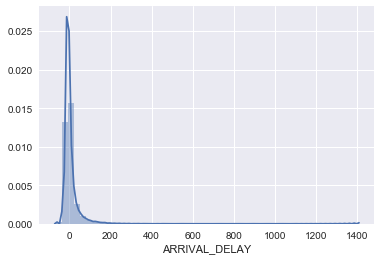

In [39]:
sns.distplot(df['ARRIVAL_DELAY']);

#### 2. The distribution of the distance

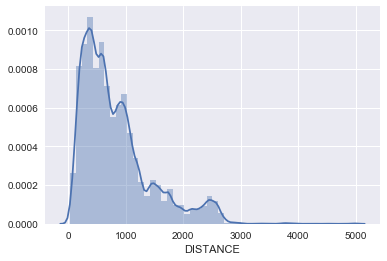

In [40]:
sns.distplot(df['DISTANCE']);

#### 3. Departure Delay VS Arrival Delay

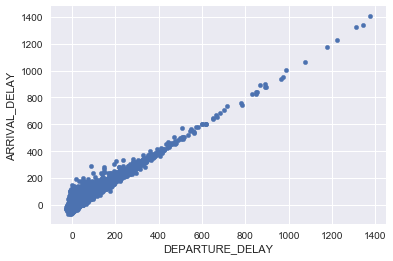

In [41]:
df.plot.scatter(x ="DEPARTURE_DELAY", y ="ARRIVAL_DELAY")
plt.show()

#### It's obvious that if the flight departs late, it will arrrive late!

#### 4. Arrival Delay VS Day

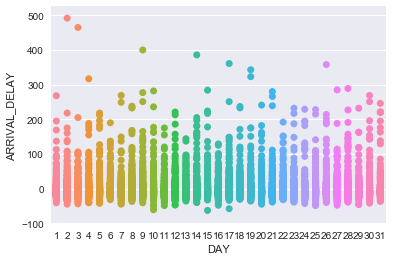

In [16]:
sns.stripplot(x="DAY", y="ARRIVAL_DELAY", data=df, size = 7);

#### 5. Arrival Delay VS Day Of Week

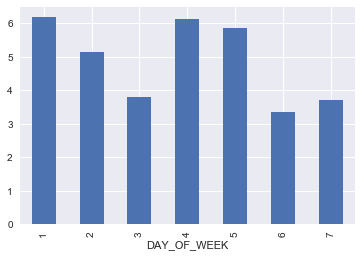

In [17]:
df.groupby("DAY_OF_WEEK")["ARRIVAL_DELAY"].mean().plot(kind="bar")
plt.show()

#### 1= Monday, 7= Sunday

#### 6. Arrival Delay VS Taxi out

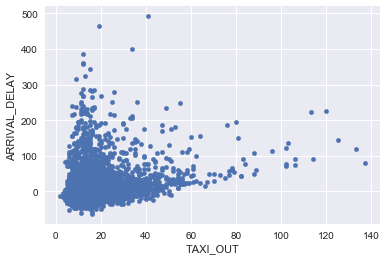

In [18]:
df.plot.scatter(x ="TAXI_OUT", y ="ARRIVAL_DELAY")
plt.show()

#### 7. Depature Delay VS Airline

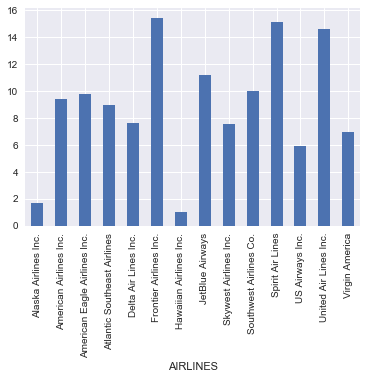

In [42]:
df.groupby("AIRLINES")["DEPARTURE_DELAY"].mean().plot(kind="bar")
plt.show()

#### 8. Depature Delay VS Months


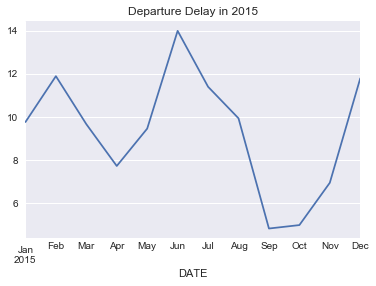

In [15]:
# DATA has the column date as an index 
DATE = pd.read_csv("flights.csv", low_memory=False)
DATE["DATE"] =  pd.to_datetime(DATE.YEAR*10000 + DATE.MONTH*100 + DATE.DAY_OF_WEEK,format='%Y%m%d')
DATE = DATE.set_index('DATE')
DATE.DEPARTURE_DELAY.resample("M").mean().plot();
plt.title("Departure Delay in 2015")
plt.show()

#### It seems that more departure delay happens on summer! It reaches the peak on July.

#### 9. Arrival Delay VS Distance

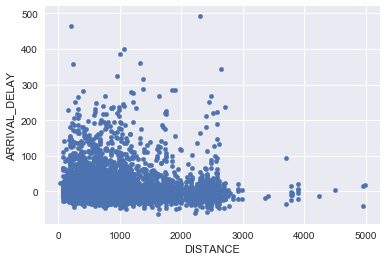

In [21]:
df.plot.scatter(x ="DISTANCE", y ="ARRIVAL_DELAY")
plt.show()

#### 10. Arrival Delay VS Airlines

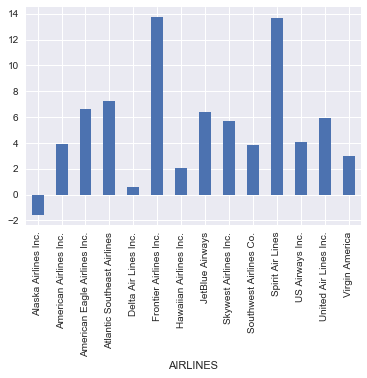

In [43]:
df.groupby("AIRLINES")["ARRIVAL_DELAY"].mean().plot(kind="bar")
plt.show()

#### 11. Airlines VS Count of Flights

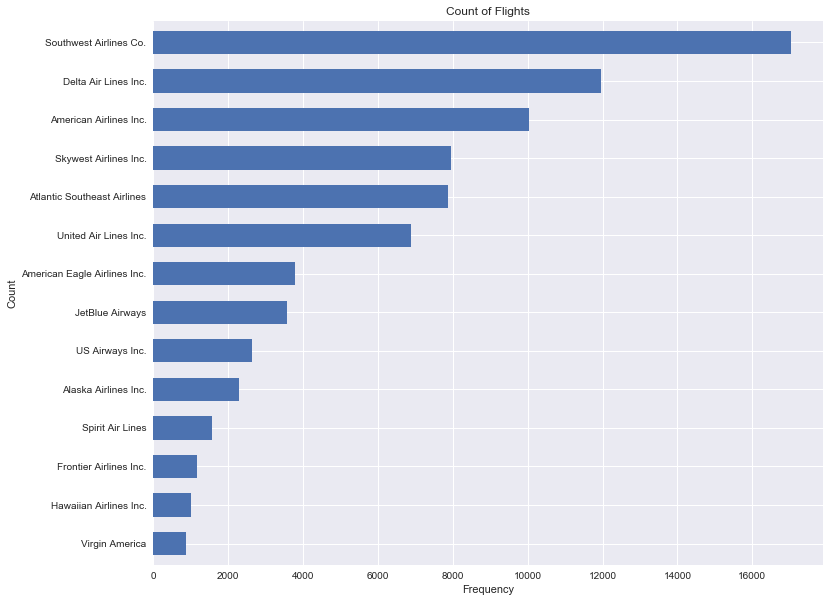

In [44]:
# Plot Airlines frequency
plt.subplots(figsize=(12,10))
df.AIRLINES.value_counts(ascending=True).plot(kind="barh", width=0.6)
plt.title("Count of Flights")
plt.xlabel("Frequency")
plt.ylabel("Count")
plt.show()

#### 12. Airlines VS Distance

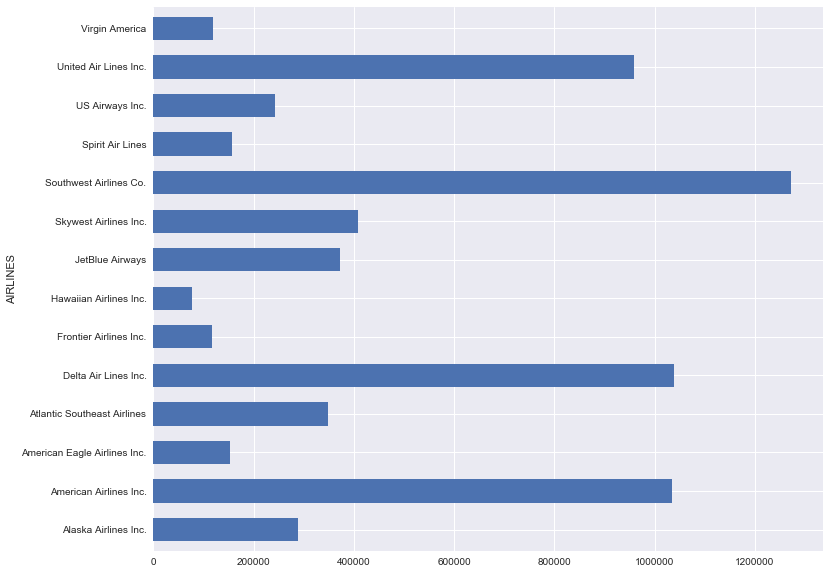

In [25]:
plt.subplots(figsize=(12,10))
df.groupby("AIRLINES")["DISTANCE"].sum().plot(kind="barh", width=0.6)
plt.show()

### C. Flights Delay Prediction

In [144]:

nums = df._get_numeric_data()
nums.drop(["DIVERTED", "CANCELLED" ],axis=1, inplace=True)
nums.corr()

,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
MONTH,1.000000,0.005643,-0.007614,-0.020791,0.001825,-0.002118,-0.022853,-0.011591,-0.003565,0.010224,0.002000,0.003327,0.010813,-0.008036,0.001967,-0.009282,-0.007822,-0.037283
DAY,0.005643,1.000000,0.002171,0.000601,-0.002945,-0.004142,-0.000450,-0.002509,-0.004758,0.001891,0.000687,0.001049,0.002061,-0.004893,-0.000449,-0.004778,-0.005221,-0.002747
DAY_OF_WEEK,-0.007614,0.002171,1.000000,0.014541,0.007556,0.005819,-0.010866,-0.021163,0.004196,0.013307,0.009998,0.012806,0.014557,0.006185,0.000891,0.006470,0.006072,-0.016831
FLIGHT_NUMBER,-0.020791,0.000601,0.014541,1.000000,-0.006190,-0.000846,-0.009081,0.050117,0.005527,-0.315422,-0.305898,-0.319014,-0.329261,-0.005996,-0.018894,-0.016117,-0.002852,0.018260
SCHEDULED_DEPARTURE,0.001825,-0.002945,0.007556,-0.006190,1.000000,0.965263,0.110109,0.008018,0.940190,-0.016149,-0.018029,-0.016018,-0.009652,0.661995,-0.044793,0.708012,0.635681,0.100430
DEPARTURE_TIME,-0.002118,-0.004142,0.005819,-0.000846,0.965263,1.000000,0.175146,0.015429,0.973175,-0.020924,-0.021925,-0.021241,-0.016967,0.681154,-0.040834,0.713245,0.653948,0.163368
DEPARTURE_DELAY,-0.022853,-0.000450,-0.010866,-0.009081,0.110109,0.175146,1.000000,0.055275,0.166665,0.027009,0.029922,0.022987,0.023506,0.062494,0.012338,0.098241,0.052522,0.944925
TAXI_OUT,-0.011591,-0.002509,-0.021163,0.050117,0.008018,0.015429,0.055275,1.000000,0.040586,0.113640,0.206507,0.088874,0.073673,0.034059,0.004569,0.025623,0.030610,0.223945
WHEELS_OFF,-0.003565,-0.004758,0.004196,0.005527,0.940190,0.973175,0.166665,0.040586,1.000000,-0.027847,-0.026480,-0.029182,-0.027387,0.700224,-0.038703,0.724568,0.672921,0.160055
SCHEDULED_TIME,0.010224,0.001891,0.013307,-0.315422,-0.016149,-0.020924,0.027009,0.113640,-0.027847,1.000000,0.985270,0.990751,0.984473,0.025033,0.098571,0.034381,0.022155,-0.030394


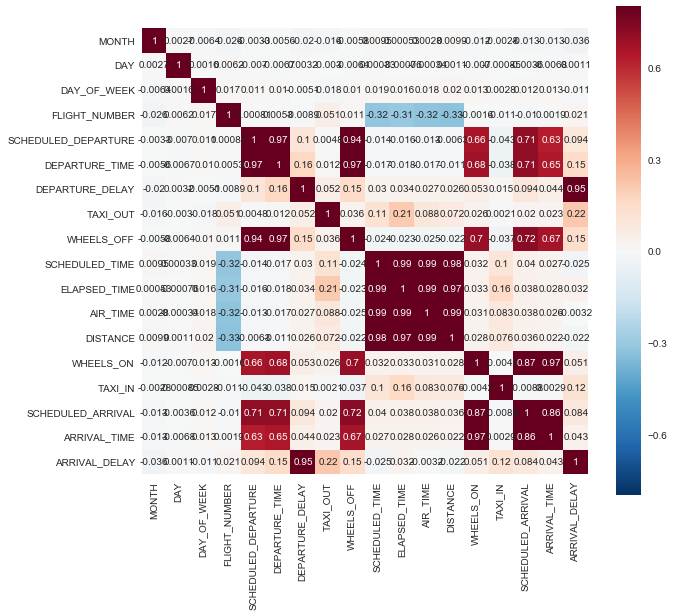

In [49]:
corrmat = nums.corr()
f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(corrmat, annot=True ,vmax=.8, square=True);

## Linear Regression

In [15]:
# Linear regression using all feature
X = nums.drop(["ARRIVAL_DELAY"], axis=1)
y = nums["ARRIVAL_DELAY"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.20, random_state=42)

X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

# Fit the model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

# Do the prediction on the test set
y_pred = regr.predict(X_test)
print('Score = ', regr.score(X_test, y_test))

rms = sqrt(mean_squared_error(y_test, y_pred))
print("RMSE  = ", rms)

('Score = ', 0.99290910585559233)
('RMSE  = ', 3.717941944113475)


In [50]:
# Linear regression Using one feature 
X = nums['DEPARTURE_DELAY']
y = nums['ARRIVAL_DELAY']

X = X[:, np.newaxis]
y = y[:, np.newaxis]

#X = preprocessing.scale(X)
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.20, random_state=42)

X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

# Fit the model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

# Do the prediction on the test set
y_pred = regr.predict(X_test)
print("Score = ",  regr.score(X_test, y_test))

rms = sqrt(mean_squared_error(y_test, y_pred))
print("RMSE  = ",  rms)

Score =  0.907025458787
RMSE  =  12.928448261126173


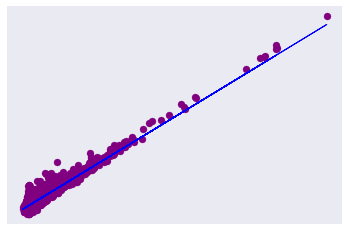

In [51]:
plt.scatter(X_test, y_test,  color='purple')
plt.plot(X_test, y_pred, color='Blue', linewidth=1)
plt.xticks(())
plt.yticks(())

plt.show()

## Logistic Regression

####  Create a column that has labels of the delay time: Early, on time. small delay, large delay


In [145]:
bins=[-100,0,25,100, 1600]
labels= ['Early','OnTime', 'SmallDelay', 'LargeDelay']
nums['Arrival_Categories']=pd.cut(nums['ARRIVAL_DELAY'], bins, labels=labels)

In [57]:
nums.head()

,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,Arrival_Categories
2462450,6,5,5,667,1355,1453.0,58.0,16.0,1509.0,76.0,86.0,65.0,338,1614.0,5.0,1511,1619.0,68.0,OnTime
2980605,7,6,1,673,1725,1720.0,-5.0,14.0,1734.0,119.0,100.0,75.0,529,1849.0,11.0,1924,1900.0,-24.0,Early
1759841,4,23,4,1155,605,602.0,-3.0,13.0,615.0,100.0,94.0,71.0,493,726.0,10.0,745,736.0,-9.0,Early
5123411,11,16,1,1956,2001,2002.0,1.0,15.0,2017.0,67.0,60.0,41.0,223,2058.0,4.0,2108,2102.0,-6.0,Early
2935004,7,3,5,2666,1655,1658.0,3.0,16.0,1714.0,58.0,57.0,37.0,181,1751.0,4.0,1753,1755.0,2.0,Early


In [146]:
nums['Arrival_Categories'].value_counts()

Early         644549
OnTime        104528
LargeDelay     21736
SmallDelay     14573
Name: Arrival_Categories, dtype: int64

In [59]:
# Now, we build the logistic regression
x=  nums.drop(['ARRIVAL_DELAY','Arrival_Categories', 'DEPARTURE_DELAY'], axis=1)
y= nums['Arrival_Categories']

#x=x.reshape(-1,1)
scaler = StandardScaler()  
scaler.fit(x) 
le = preprocessing.LabelEncoder()
y= le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)


logistic= linear_model.LogisticRegression()
logistic.fit(X_train,y_train)
y_pred=logistic.predict(X_test)
print("Accuracy =", accuracy_score(y_test, y_pred))


Accuracy = 0.851500890359


In [60]:
cm=confusion_matrix(y_test, y_pred)
cm

array([[12903,     0,    10,     0],
       [   54,   142,   241,     0],
       [ 1736,     1,   344,     0],
       [  143,     8,   142,     0]])

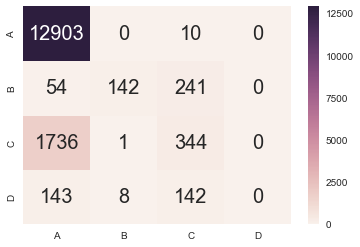

In [66]:
df_cm = pd.DataFrame(cm, index = [i for i in "ABCD"],
                  columns = [i for i in "ABCD"])
#sns.set(font_scale=.1)#for label size
sns.heatmap(df_cm, annot=True, fmt= '',  annot_kws={"size": 20})# font size

In [67]:
print(classification_report(y_test,y_pred))  

             precision    recall  f1-score   support

          0       0.87      1.00      0.93     12913
          1       0.94      0.32      0.48       437
          2       0.47      0.17      0.24      2081
          3       0.00      0.00      0.00       293

avg / total       0.80      0.85      0.81     15724



# Support Vector Machine (SVM)

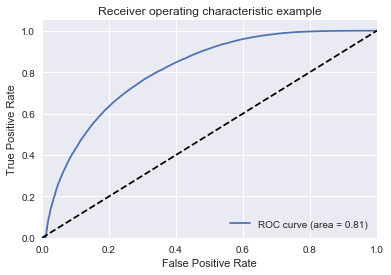

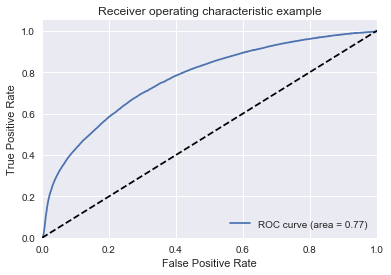

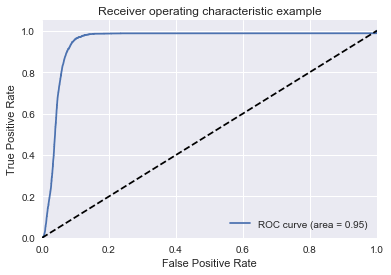

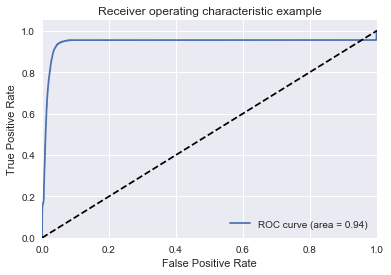

In [147]:
## One vs all 
x=  nums.drop(['ARRIVAL_DELAY','Arrival_Categories','DEPARTURE_DELAY'], axis=1)
y= nums['Arrival_Categories']


# ROC


y = label_binarize(y,classes=['Early','OnTime','SmallDelay', 'LargeDelay'])
n_classes = 4
# Compute ROC curve and ROC area for each class
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=33)
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)
# classifier
clf= OneVsRestClassifier(LinearSVC(random_state=20))
y_score = clf.fit(X_train, y_train).decision_function(X_test)
y_pred=clf.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [150]:
print("Accuracy =", accuracy_score(y_test, y_pred))

('Accuracy =', 0.82305606131985387)


In [149]:
print(classification_report(y_test,y_pred))  

             precision    recall  f1-score   support

          0       0.85      1.00      0.92    129074
          1       0.46      0.03      0.06     20823
          2       0.00      0.00      0.00      2913
          3       0.73      0.01      0.01      4268

avg / total       0.78      0.82      0.76    157078



## K-Nearest Neighbors ( KNN) 

In [38]:
# KNN model 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import neighbors

x=  nums.drop(['ARRIVAL_DELAY','Arrival_Categories','DEPARTURE_DELAY'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
x, y, test_size=0.20, random_state=40)
k = 7
knn = KNeighborsClassifier(n_neighbors=k)
accuracy = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
print (accuracy.mean())

0.817985954384


In [80]:
# create a loop to find best value of k 
# Using the corss validation

accuracy_array = []
k_array = []
for k in range(3,50,2):
    knn = KNeighborsClassifier(n_neighbors=k)
    accuracy = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    accuracy_array.append(accuracy.mean())
    k_array.append(k)
print (accuracy_array)
print(k_array)

[0.8255540177222036, 0.82084347507914546, 0.81864649453538885, 0.81734198762309285, 0.81663405399385935, 0.81620133950587825, 0.81604066243497342, 0.81617588571246757, 0.81618861260917297, 0.81638110692184096, 0.81639224295645807, 0.8164861038196598, 0.81668814330485695, 0.81682813916861541, 0.8168583655482905, 0.81693472692852254, 0.81708744968898639, 0.8171351755516314, 0.81719403744889352, 0.81728948917418354, 0.81737698658903246, 0.81745652969344085, 0.81741834900332488, 0.81750743728026209]
[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]


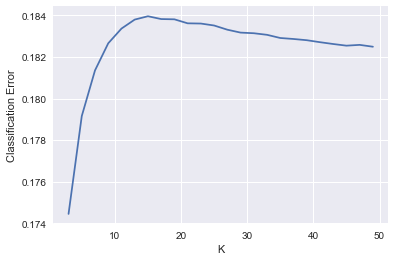

In [82]:
class_error = 1.0 - np.array(accuracy_array)
plt.plot(k_array, class_error)
plt.xlabel('K')
plt.ylabel('Classification Error')
plt.show()

In [83]:
#finding optimal value of k , generated by cross validation
min_ind = np.argmin(class_error)
OptK = k_array[min_ind]
print ("Optimal value of K is %d " %  OptK)

Optimal value of K is 3 


In [84]:
# Use Optimal value of K for test set
knn = KNeighborsClassifier(n_neighbors=OptK)

# fitting the model
knn.fit(X_train, y_train)

# predict
y_predictions = knn.predict(X_test)

# evaluate accuracy
print(accuracy_score(y_test, y_predictions ))

0.828639244534


In [86]:
print(classification_report(y_test,y_predictions))  

             precision    recall  f1-score   support

          0       0.87      0.96      0.91    129206
          1       0.53      0.27      0.36     20798
          2       0.27      0.05      0.08      2914
          3       0.54      0.13      0.21      4230

avg / total       0.81      0.83      0.81    157148



## Neural Network with Scikit-Learn

In [135]:
#NN
# This is only sample of 800000


x=  nums.drop(['ARRIVAL_DELAY','Arrival_Categories','DEPARTURE_DELAY'], axis=1)
y= nums['Arrival_Categories']
#y=y.reshape(-1,1)

le = preprocessing.LabelEncoder()
y= le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=44)
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

mlp = MLPClassifier(hidden_layer_sizes=(30,20,10), max_iter=1000)  
mlp.fit(X_train, y_train)
y_predictions = mlp.predict(X_test)  

print("Accuracy =", accuracy_score(y_test, y_predictions))

('Accuracy =', 0.98697666523934624)


In [136]:
print(confusion_matrix(y_test,y_predictions))  

[[211251      1   1687      0]
 [     1   6937      1    286]
 [   601     11  33306    199]
 [     1    306    282   4357]]


In [137]:
print(classification_report(y_test,y_predictions))  

             precision    recall  f1-score   support

          0       1.00      0.99      0.99    212939
          1       0.96      0.96      0.96      7225
          2       0.94      0.98      0.96     34117
          3       0.90      0.88      0.89      4946

avg / total       0.99      0.99      0.99    259227



# The Conclusion

| Results  | Logistic Regression |SVM  |KNN  | NN |
|----------|---------------------|-----|-----|----|
|precision |80        |  78 |  81 | 99 |
|recall    |85        |  82 |  83 | 99 |
|f1-score  |81        |  76 |  81 | 99 |
|Accuracy  |85        |  82 |  82 | 99 |